## Classification of Covid 19 tweets to assertain what can be learnt about public knowledge on symptoms, treatment and prevention of the virus

this project is an effort to contribute to health surveillance in order to help medical professionals coalate useful information to aid in intervention measures in the situation of an outbreak

The objectives of this project are:

1. implementation of bert algorithm 
2. aid in labelling large data
3. information gathering


## Data processing

### Processing literature data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load covid literature data
covid_literature_df = pd.read_csv('C:/Users/Sammy/2021/final-project/data/metadata.csv', usecols=['title','abstract','authors','doi','publish_time','pdf_json_files'])
np.random.seed()


C:\Users\Sammy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
covid_literature_df.head()

,title,doi,abstract,publish_time,authors,pdf_json_files
0,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",document_parses/pdf_json/d1aafb70c066a2068b027...
1,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",document_parses/pdf_json/6b0567729c2143a66d737...
2,Surfactant protein-D and pulmonary host defense,10.1186/rr19,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",document_parses/pdf_json/06ced00a5fc04215949aa...
3,Role of endothelin-1 in lung disease,10.1186/rr44,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",document_parses/pdf_json/348055649b6b8cf2b9a37...
4,Gene expression in epithelial cells in respons...,10.1186/rr61,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",document_parses/pdf_json/5f48792a5fa08bed9f560...


In [4]:
#missing values
missing_values = covid_literature_df.isnull().sum()
missing_values

title                216
doi               180633
abstract          115815
publish_time         220
authors            12283
pdf_json_files    274650
dtype: int64

In [5]:
#percentage of missing data
all_cells = np.product(covid_literature_df.shape)
all_missing = missing_values.sum()
percentage_missing = (all_missing/all_cells)*100
print(percentage_missing)

23.501964478366585


In [6]:
#drop duplicates and fill missing values
covid_literature_df.duplicated()
covid_literature_df.drop_duplicates(keep='first', inplace=True)
covid_literature_df.fillna('no text available', inplace = True)

In [7]:
covid_literature_df['abstract'] = (covid_literature_df['title']+ ' ' + covid_literature_df['abstract']).apply(lambda row: row.strip())

In [8]:
covid_literature_df['abstract'] = covid_literature_df['abstract'].apply(lambda row: row.replace('no text available',''))

In [9]:
#reduce the dataset to literature discussing covid specific topics
def find_covid_lit(df):
    df1 = df[df['abstract'].str.contains('ncov')]
    df2 = df[df['abstract'].str.contains('corona')]
    df3 = df[df['abstract'].str.contains('covid')]
    df4 = df[df['abstract'].str.contains('-cov-2')]
    df5 = df[df['abstract'].str.contains('cov2')]
    
    
    data =[df1,df2,df3,df4,df5]
    df = pd.concat(data)
    df=df.drop_duplicates(subset='title', keep="first")
    return df
    
df=find_covid_lit(covid_literature_df)
print (df.shape)
df.head()   

(70814, 6)


,title,doi,abstract,publish_time,authors,pdf_json_files
524,Genomic Signatures of Strain Selection and Enh...,10.1371/journal.pone.0017836,Genomic Signatures of Strain Selection and Enh...,2011-03-25,"Gibbons, Henry S.; Broomall, Stacey M.; McNew,...",document_parses/pdf_json/6cc30d377f0bd9004378e...
549,The Multifaceted Poliovirus 2A Protease: Regul...,10.1155/2011/369648,The Multifaceted Poliovirus 2A Protease: Regul...,2011-04-14,"Castelló, Alfredo; Álvarez, Enrique; Carrasco,...",document_parses/pdf_json/5bff40b0df656057c9db8...
621,Dominating Biological Networks,10.1371/journal.pone.0023016,Dominating Biological Networks Proteins are es...,2011-08-26,"Milenković, Tijana; Memišević, Vesna; Bonato, ...",document_parses/pdf_json/d0acac75cb3d2c19abfe0...
784,Both TLR2 and TRIF Contribute to Interferon-β ...,10.1371/journal.pone.0033299,Both TLR2 and TRIF Contribute to Interferon-β ...,2012-03-14,"Aubry, Camille; Corr, Sinéad C.; Wienerroither...",document_parses/pdf_json/2305cbae32a50cf992335...
884,Proteasome-Dependent Disruption of the E3 Ubiq...,10.1371/journal.ppat.1002789,Proteasome-Dependent Disruption of the E3 Ubiq...,2012-07-05,"Fehr, Anthony R.; Gualberto, Nathaniel C.; Sav...",document_parses/pdf_json/5ae7223cc6ab3437ba262...


### labeling the literature data based on terms in the abstract

In [10]:
import functools
from nltk import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

# converts terms to morphological root eg. smoked and smoking to smok
def stemmer(words):
    stemmer = PorterStemmer()
    tokens=[]
    for w in words:
        tokens.append(stemmer.stem(w))
    return tokens


def get_sentences(df1,search_terms,str1):
    df_table = pd.DataFrame(columns = ["pub_date","authors","title","excerpt",'label'])
    search_terms=stemmer(search_terms)
    for index, row in df1.iterrows():
        
        pub_sentence=''
        sentences_used=0
        
        sentences = row['abstract'].split('. ')
        
        highligts=[]
        for sentence in sentences:
            
            missing=0
            
            for word in search_terms:
                
                if word not in sentence:
                    missing=1
                    
            
            if missing==0 and len(sentence)<1000 and sentence!='':
                sentence=sentence.capitalize()
                if sentence[len(sentence)-1]!='.':
                    sentence=sentence+'.'
                pub_sentence=pub_sentence+sentence
                
        if pub_sentence!='':
            sentence=pub_sentence
            sentences_used=sentences_used+1
            authors=row["authors"].split(" ")            
            title=row["title"]                       
            to_append = [row['publish_time'],authors[0]+' et al.',title,sentence,str1]
            df_length = len(df_table)
            df_table.loc[df_length] = to_append
    return df_table


def search_dataframe(df,search_terms):   
    search_words=stemmer(search_terms)
    df1=df[functools.reduce(lambda a, b: a&b, (df['abstract'].str.contains(s) for s in search_terms))]
    return df1





C:\Users\Sammy\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [11]:
#list of labels and list of search terms per label
labels = ['transmission','treatment','symptom','health risk', 'prevention']
search=[['transmission','infection','case'],['treatment','care'],['symptom','asymptomatic'],['risk','vulnerable','affect'],['prevent','quarantine']]
label_table = ['','','','','']
q=0


for search_terms in search:
    #str1=''
    str1 = labels[q]
    
    #search the dataframe for all words
    df1=search_dataframe(df,search_terms)
   
    # get best sentences
    df_table=get_sentences(df1,search_terms,str1)    
    
    length=df_table.shape[0]

    if length<1:
        print ("No reliable data could be located in the literature")
    else:
        display(df_table.head())
    label_table[q] = df_table
    q=q+1
    
print ('done')

,pub_date,authors,title,excerpt,label
0,2020-11-20,"Boshier, et al.",Remdesivir induced viral RNA and subgenomic RN...,We conclude that these are likely to have aris...,transmission
1,2020-01-03,"Chertow, et al.","Influenza, Measles, SARS, MERS, and Smallpox",Early case identification and strict infection...,transmission
2,2020-09-17,"Gupta, et al.",Estimating the Impact of Daily Weather on the ...,"Daily maximum (t(max)), minimum (t(min)), mean...",transmission
3,2015,"Al-Tawfiq, et al.",Middle East respiratory syndrome coronavirus i...,"Data suggest the overcrowding, late recognitio...",transmission
4,2020-06-17,"Jing, et al.",Household secondary attack rate of COVID-19 an...,We assessed the demographic determinants of tr...,transmission


,pub_date,authors,title,excerpt,label
0,2020-12-23,"Taylor, et al.",Awake-Prone Positioning Strategy for Non-Intub...,Five inpatient medical service teams were rand...,treatment
1,2020-06-01,"Blais, et al.",Consensus statement: summary of the Quebec Lun...,"For each level-of-activity scenario, suggestio...",treatment
2,2020,"Taylor, et al.",Awake-Prone Positioning Strategy for Non-Intub...,Five inpatient medical service teams were rand...,treatment
3,2020,"Berman, et al.",Supportive Care: An Indispensable Component of...,The current focus of cancer care is on initial...,treatment
4,2020,"Chamsi-Pasha, et al.",Ethical dilemmas in the era of COVID-19,"Across the globe, hospitals are being challeng...",treatment


,pub_date,authors,title,excerpt,label
0,2016-03-24,"Ziegler, et al.",The Lymphocytic Choriomeningitis Virus Matrix ...,The lymphocytic choriomeningitis virus matrix ...,symptom
1,2019,"Erben, et al.",Multicenter experience with endovascular treat...,Clinical presentation included asymptomatic in...,symptom
2,2020-11-20,"Badgujar, et al.",Structural insights into loss of function of a...,The opportunistic pathogen streptococcus pneum...,symptom
3,2011,"Gray, et al.",Influence of site and operator characteristics...,Methods in this assessment of the capture 2 st...,symptom
4,2016,"Brachmann, et al.",Uncovering Atrial Fibrillation Beyond Short-Te...,"However, af can be paroxysmal and asymptomatic...",symptom


,pub_date,authors,title,excerpt,label
0,2020-11-04,"Eufemia, et al.",Peacebuilding in times of COVID-19: risk-adapt...,"After reviewing academic and grey literature, ...",health risk
1,2020,"Torres-Pinzon, et al.",Coronavirus Disease 2019 and the Case to Cover...,Coronavirus disease 2019 and the case to cover...,health risk
2,2020,"Stasevic-Karlicic, et al.",Perspectives on mental health services during ...,Perspectives on mental health services during ...,health risk
3,2020,"Cattaneo, et al.",Clinical characteristics and risk factors for ...,Clinical characteristics and risk factors for ...,health risk
4,2020-04-06,"Islam, et al.",Modeling risk of infectious diseases: a case o...,Results according to the calculated risk index...,health risk


,pub_date,authors,title,excerpt,label
0,2020-09-21,"Su, et al.",Early diagnosis and population prevention of c...,Due to the lack of effective drugs and vaccine...,prevention
1,2020-06-17,"Jing, et al.",Household secondary attack rate of COVID-19 an...,"In addition to case finding and isolation, tim...",prevention
2,2020-09-01,"Ayenigbara, et al.","COVID-19 (SARS-CoV-2) pandemic: fears, facts a...",The world is faced with containing the spread ...,prevention
3,2020-05-13,"Singh, et al.",Knowledge and Perception Towards Universal Saf...,Although participants' overall knowledge score...,prevention
4,2020-11-04,Feiz et al.,The health effects of quarantine during the CO...,"In the case of the coronavirus epidemic, quara...",prevention


done


In [12]:
covid_data = pd.concat([label_table[0],label_table[1],label_table[2],label_table[3],label_table[4]],axis = 0)
covid_data.reset_index()

,index,pub_date,authors,title,excerpt,label
0,0,2020-11-20,"Boshier, et al.",Remdesivir induced viral RNA and subgenomic RN...,We conclude that these are likely to have aris...,transmission
1,1,2020-01-03,"Chertow, et al.","Influenza, Measles, SARS, MERS, and Smallpox",Early case identification and strict infection...,transmission
2,2,2020-09-17,"Gupta, et al.",Estimating the Impact of Daily Weather on the ...,"Daily maximum (t(max)), minimum (t(min)), mean...",transmission
3,3,2015,"Al-Tawfiq, et al.",Middle East respiratory syndrome coronavirus i...,"Data suggest the overcrowding, late recognitio...",transmission
4,4,2020-06-17,"Jing, et al.",Household secondary attack rate of COVID-19 an...,We assessed the demographic determinants of tr...,transmission
5,5,2020-07-09,"Rockett, et al.",Revealing COVID-19 transmission in Australia b...,We report that the prospective sequencing of s...,transmission
6,6,2020-02-27,"Zhu, et al.",[Challenges and countermeasures on Chinese mal...,Due to the extensive spread and high transmiss...,transmission
7,7,2020-04-08,"Wang, et al.",Current trends and future prediction of novel ...,"Based on the current control measures, we prop...",transmission
8,8,2020-02-06,no et al.,"2019-nCoV acute respiratory disease, Australia...",It includes data on australian cases notified ...,transmission
9,9,2020-07-14,"Bahramian, et al.",COVID-19 Considerations in Pediatric Dentistry.,"Therefore, we need to beware of the symptoms a...",transmission


In [13]:
covid_data.sample(20)

,pub_date,authors,title,excerpt,label
1425,2020,"Alhetheel, et al.",Assessment of Th1/Th2 cytokines among patients...,This study was conducted to assess the plasma ...,symptom
37,2020-06-15,"Jeyabalan, et al.",Anesthesia for Cardiac Surgery during COVID-19...,Patients with covid-19 can progress from asymp...,symptom
17,2012-05-11,"Benato, et al.",Respiratory diseases in rats,Medical treatment generally includes oxygen th...,treatment
210,2008-03-29,"Gagneur, et al.",Materno-fetal transmission of human coronaviru...,Materno-fetal transmission of human coronaviru...,transmission
1065,2020,"Baggett, et al.",Addressing COVID-19 Among People Experiencing ...,Components included symptom screening at shelt...,symptom
796,2020,"Gupta, et al.",Management and outcomes of patients hospitaliz...,Management and outcomes of patients hospitaliz...,treatment
2384,2020-09-01,"Zhou, et al.",Clinical and imaging findings of discharged pa...,The incidence of asymptomatic cases in the pos...,symptom
1554,2020,"Shental, et al.",Efficient high-throughput SARS-CoV-2 testing t...,Efficient high-throughput sars-cov-2 testing t...,symptom
1717,2020,"Franczuk, et al.",Spirometry during the SARS-CoV-2 pandemic. Gui...,"According to current knowledge, the source of ...",symptom
426,2020,de et al.,Impact of the coronavirus disease 2019 pandemi...,Impact of the coronavirus disease 2019 pandemi...,treatment


In [14]:
covid_data['label'].value_counts()

symptom         2464
treatment       1149
transmission     239
prevention       189
health risk        8
Name: label, dtype: int64

In [15]:
import preprocessor as tp

In [16]:
#!pip install tweet-preprocessor

In [17]:
#remove stop words and further processing
def stopword_remover_ex(row):
    text = row['excerpt']
    text = remove_stopwords(text)
    return text   

In [18]:
covid_data['excerpt'] = covid_data.apply(stopword_remover_ex,axis = 1)
covid_data['excerpt'] = covid_data['excerpt'].str.lower().str.strip()

### Processing tweet data

In [19]:
tweet_data = pd.read_csv('C:/Users/Sammy/OneDrive/Documents/tweets.csv')

In [20]:
print(tweet_data.head())
tweet_data.shape

                                                text         label
0  The question we need urgent answer to is how l...  transmission
1  it takes like 2 weeks for symptoms to start sh...       symptom
2  Fort Bend County has a confirmed Coronavirus p...    prevention
3  China confirms 170 deaths as coronavirus sprea...       symptom
4  Excellent discussion from @PascalJabbourMD on ...   health risk


(374, 2)

In [21]:
tweet_data['label'].value_counts(normalize=False)

prevention      161
transmission     84
symptom          62
treatment        53
health risk      14
Name: label, dtype: int64

In [22]:
tweet_data.count()

text     374
label    374
dtype: int64

In [23]:
tweet_data.drop_duplicates(inplace=True)
tweet_data.dropna(inplace=True)

In [24]:
tweet_data.count()

text     374
label    374
dtype: int64

In [25]:
tweet_data.head()

,text,label
0,The question we need urgent answer to is how l...,transmission
1,it takes like 2 weeks for symptoms to start sh...,symptom
2,Fort Bend County has a confirmed Coronavirus p...,prevention
3,China confirms 170 deaths as coronavirus sprea...,symptom
4,Excellent discussion from @PascalJabbourMD on ...,health risk


### Pre-process tweets

In [26]:
def tweet_processor(row):
    
    tweet = row['text']
    tweet = tp.clean(tweet)
    
    return tweet
    

In [27]:
tweet_data['text'] = tweet_data.apply(tweet_processor,axis = 1)

In [28]:
tweet_data.head()

,text,label
0,The question we need urgent answer to is how l...,transmission
1,it takes like weeks for symptoms to start show...,symptom
2,Fort Bend County has a confirmed Coronavirus p...,prevention
3,China confirms deaths as coronavirus spreads t...,symptom
4,Excellent discussion from on cases during,health risk


In [29]:
#remove stop words and further processing
def stopword_remover(row):
    text = row['text']
    text = remove_stopwords(text)
    return text   
    

In [30]:
tweet_data['text'] = tweet_data.apply(stopword_remover,axis = 1)

In [31]:
tweet_data['text'] = tweet_data['text'].str.lower().str.strip()

In [32]:
#tweet_data['text'].str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

####  Defining our base model

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
tweet = tweet_data['text'].values
y_label = tweet_data['label'].values

In [35]:
tweet_train, tweet_test, tweet_y_train, tweet_y_test = train_test_split(tweet, y_label,test_size = 0.25, random_state = 42)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
vectorizer = CountVectorizer()
vectorizer.fit(tweet_train)

X_train = vectorizer.transform(tweet_train)
X_test = vectorizer.transform(tweet_test)

In [ ]:
len(tweet)
#X_train

In [41]:
# y_train = pd.factorize(tweet_y_train)
# y_test = pd.factorize(tweet_y_test)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 

#### Decision tree classifier model

In [43]:
classifier = DecisionTreeClassifier(max_depth = 2)
classifier.fit(X_train,tweet_y_train)
score = classifier.score(X_test,tweet_y_test)
print("Accuracy:", score)

predictions = classifier.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(tweet_y_test, predictions) 
cm

Accuracy: 0.39361702127659576


array([[ 0,  5,  0,  0,  0],
       [ 0, 37,  0,  0,  0],
       [ 0, 14,  0,  0,  0],
       [ 0, 27,  0,  0,  0],
       [ 0, 11,  0,  0,  0]], dtype=int64)

#### Logistic regression model

In [44]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,tweet_y_train)
lr_score = lr_classifier.score(X_test,tweet_y_test)
print("Accuracy:", lr_score)

predictions = lr_classifier.predict(X_test) 
  
# creating a confusion matrix 
lr_cm = confusion_matrix(tweet_y_test, predictions) 
lr_cm

Accuracy: 0.5425531914893617


array([[ 0,  4,  0,  1,  0],
       [ 0, 29,  4,  4,  0],
       [ 0,  6,  5,  3,  0],
       [ 0, 11,  2, 13,  1],
       [ 0,  5,  0,  2,  4]], dtype=int64)

### Implementing BERT with keras

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [37]:
#!pip install wget
#import wget

In [38]:
# url = 'https://raw.githubusercontent.com/google-research/bert/master/tokenization.py'
# filename = wget.download(url)

In [39]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(model_url, trainable=True)

INFO:absl:Using C:\Users\Sammy\AppData\Local\Temp\tfhub_modules to cache modules.


In [40]:
import tokenization

In [41]:
vocabs_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_casing = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocabs_file, do_lower_casing)

In [42]:
#sample tokens

#note the output of this 
sentence = 'By defining the three metadata tokens created from the input data. token embeddings, position embeddings and sequence embeddings'
output_text = tokenizer.tokenize(sentence)

In [43]:
print(output_text)

['by', 'defining', 'the', 'three', 'metadata', 'token', '##s', 'created', 'from', 'the', 'input', 'data', '.', 'token', 'em', '##bed', '##ding', '##s', ',', 'position', 'em', '##bed', '##ding', '##s', 'and', 'sequence', 'em', '##bed', '##ding', '##s']


In [44]:
output_text = tokenizer.convert_tokens_to_ids(output_text)
print(output_text)

[2011, 12854, 1996, 2093, 27425, 19204, 2015, 2580, 2013, 1996, 7953, 2951, 1012, 19204, 7861, 8270, 4667, 2015, 1010, 2597, 7861, 8270, 4667, 2015, 1998, 5537, 7861, 8270, 4667, 2015]


BERT uses an encoder. We define the bert_encoder function which processes the input sequence of the to the model. By defining the three metadata tokens created from the input data. token embeddings, position embeddings and sequence embeddings. we include the [CLS] token at the beginning of each sequence and [SEP] at the end of each sequence and between a pair of sequences. The maximum length of input is 512. for an input with length less than this we include the [PAD] token.

In [45]:
def bert_encoder(lines, tokenizer, max_len=512):
    token_embeddings = []
    mask_embeddings = []
    segment_embeddings = []
    
    #tokenizing input sequences
    for line in lines:
        line = tokenizer.tokenize(line)
            
        line = line[:max_len-2]
        input_seq = ["[CLS]"] + line + ["[SEP]"]
        pad_len = max_len - len(input_seq)
        
        tokens = tokenizer.convert_tokens_to_ids(input_seq) + [0] * pad_len
        pad_masks = [1] * len(input_seq) + [0] * pad_len
        segments_id = [0] * max_len
        
        token_embeddings.append(tokens)
        mask_embeddings.append(pad_masks)
        segment_embeddings.append(segments_id)
    
    return np.array(token_embeddings), np.array(mask_embeddings), np.array(segment_embeddings)

We build the Bert model using keras. We define the input layers, the output layers, dense and dropout layer.

In [46]:

def build_bert_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [47]:
from collections import Counter
tweet_y_train = pd.factorize(tweet_y_train)[0]
tweet_y_test = pd.factorize(tweet_y_test)[0]
print(Counter(tweet_y_train))

Counter({2: 124, 0: 57, 1: 48, 4: 42, 3: 9})


In [48]:
max_len = 150
train_input = bert_encoder(tweet_train, tokenizer, max_len=max_len)
test_input = bert_encoder(tweet_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(tweet_y_train, num_classes=5)
#test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)

In [49]:
train_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [50]:
model = build_bert_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

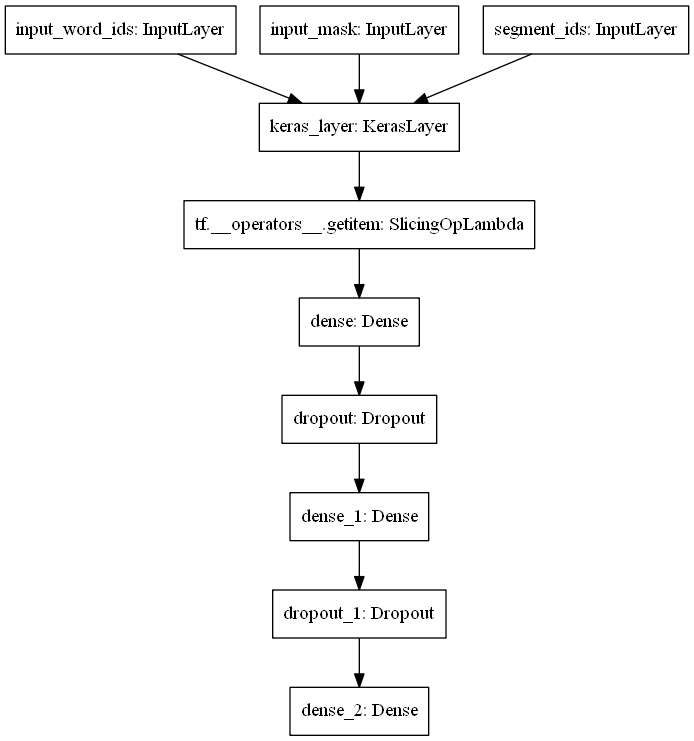

In [51]:
tf.keras.utils.plot_model(model, "my_bert_model.png")

In [104]:
#computing the class weights due to class imbalance

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',np.unique(tweet_y_train),tweet_y_train)

print('class weights {}'.format(weights))

weight_dict = dict(enumerate(weights))
weight_dict


class weights [0.98245614 1.16666667 0.4516129  6.22222222 1.33333333]


C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 1 2 1 0 2 3 0 2 2 3 4 2 2 2 2 1 4 2 2 4 2 0 0 4 1 4 0 0 2 1 4 1 0 1 2
 4 2 1 2 2 4 0 2 2 2 4 2 2 1 2 2 3 2 1 1 3 2 0 2 2 2 2 2 0 2 0 4 1 2 4 0 0
 2 0 1 2 2 2 2 1 1 0 1 4 1 2 4 4 2 2 4 0 1 2 2 2 4 2 2 2 2 2 3 1 1 1 2 2 0
 1 1 4 2 1 3 4 0 0 2 4 2 4 2 4 0 0 0 1 2 2 0 0 2 4 0 1 1 2 2 1 4 1 0 2 2 2
 2 4 2 2 0 4 2 2 2 2 1 1 4 2 4 4 2 3 2 2 2 1 2 0 4 2 2 2 2 4 2 2 2 2 2 1 2
 0 2 3 2 2 2 4 1 2 1 0 4 0 2 2 2 0 0 4 2 0 2 2 1 4 1 0 2 4 0 2 0 0 0 2 1 4
 2 3 2 0 4 4 2 2 2 0 2 4 2 0 1 2 2 0 0 2 2 1 0 0 0 2 2 2 0 0 4 1 2 0 2 1 1
 2 2 2 2 2 1 1 1 4 1 0 0 2 0 1 2 2 0 4 2 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 0.9824561403508771,
 1: 1.1666666666666667,
 2: 0.45161290322580644,
 3: 6.222222222222222,
 4: 1.3333333333333333}

In [132]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
    class_weight = weight_dict
)


Epoch 1/20


KeyboardInterrupt: 

In [112]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)


In [130]:
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [129]:
# loss, accuracy = model.evaluate(test_input, test_labels, verbose=1)
# print("Test Accuracy:  {:.4f}".format(accuracy))

In [128]:
# loss, accuracy = model.evaluate(train_input, train_labels, verbose=1)
# print("Train Accuracy: {:.4f}".format(accuracy))

In [123]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.28      0.19      0.23        37
           1       0.31      0.36      0.33        14
           2       0.17      0.30      0.22        27
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         5

    accuracy                           0.21        94
   macro avg       0.15      0.17      0.16        94
weighted avg       0.21      0.21      0.20        94



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
print(train_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [68]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(train_history):
    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


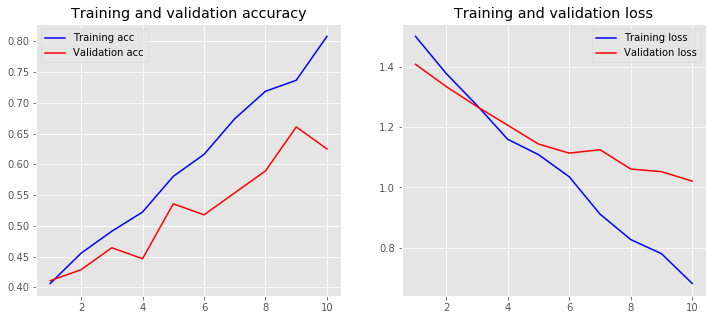

In [127]:
plot_history(train_history)

In [131]:
from tensorflow.keras.backend import clear_session
clear_session()

In [107]:
del model

### BERT implementation with literature as training data

In [53]:
text_train = covid_data['excerpt']
text_y_train = covid_data['label']

In [54]:
text_y_train = pd.factorize(text_y_train)[0]

In [55]:
#computing the class weights due to class imbalance

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',np.unique(text_y_train),text_y_train)

print('class weights {}'.format(weights))

weight_dict = dict(enumerate(weights))
weight_dict


class weights [  3.38828452   0.70478677   0.3286526  101.225        4.28465608]


C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 3.388284518828452,
 1: 0.704786771105309,
 2: 0.3286525974025974,
 3: 101.225,
 4: 4.284656084656085}

In [56]:
max_len = 100
train_input = bert_encoder(text_train, tokenizer, max_len=max_len)
test_input = bert_encoder(tweet_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(text_y_train, num_classes=5)
#test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)

In [64]:
test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)

In [57]:
model2 = build_bert_model(bert_layer, max_len=max_len)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [60]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history_lt = model2.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=50,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
    class_weight = weight_dict
    
)

Epoch 1/50
102/102 [==============================] - 2468s 24s/step - loss: 0.3311 - accuracy: 0.9194 - val_loss: 1.5165 - val_accuracy: 0.7407

Epoch 00001: val_accuracy improved from -inf to 0.74074, saving model to model_1.h5
Epoch 2/50
102/102 [==============================] - 2494s 24s/step - loss: 0.1820 - accuracy: 0.9321 - val_loss: 1.6864 - val_accuracy: 0.7346

Epoch 00002: val_accuracy did not improve from 0.74074
Epoch 3/50
102/102 [==============================] - 2526s 25s/step - loss: 0.1192 - accuracy: 0.9562 - val_loss: 1.8487 - val_accuracy: 0.7198

Epoch 00003: val_accuracy did not improve from 0.74074
Epoch 4/50
102/102 [==============================] - 2518s 25s/step - loss: 0.0932 - accuracy: 0.9630 - val_loss: 2.1726 - val_accuracy: 0.6963

Epoch 00004: val_accuracy did not improve from 0.74074
Epoch 5/50
102/102 [==============================] - 2519s 25s/step - loss: 0.0791 - accuracy: 0.9691 - val_loss: 2.1267 - val_accuracy: 0.7420

Epoch 00005: val_accu

In [61]:
model2.load_weights('model_1.h5')
test_pred = model2.predict(test_input)

In [62]:
# loss, accuracy = model2.evaluate(train_input, train_labels, verbose=1)
# print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(test_input, test_pred, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

3/3 [==============================] - 18s 6s/step - loss: 0.6657 - accuracy: 1.0000
Testing Accuracy:  1.0000


In [66]:
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [69]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.39      0.30      0.34        37
           1       0.18      0.43      0.25        14
           2       0.28      0.33      0.31        27
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         5

    accuracy                           0.28        94
   macro avg       0.17      0.21      0.18        94
weighted avg       0.26      0.28      0.26        94



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


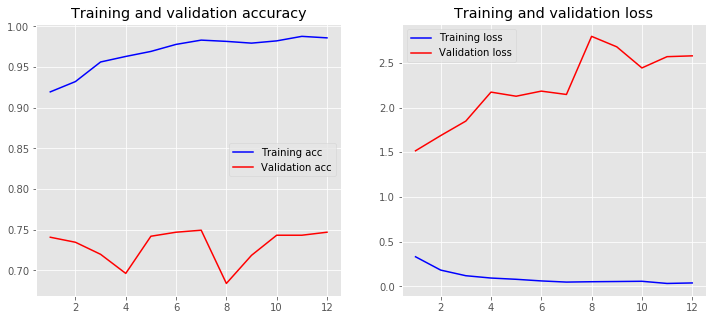

In [70]:
import matplotlib.pyplot as plt
plot_history(train_history_lt)

In [71]:
from tensorflow.keras.backend import clear_session
clear_session()

### BERT implementation with literature and tweets as training data

In [ ]:
# merge tweets and covid data

covid_data_copy = covid_data.copy()
covid_data_copy.rename(columns = {'excerpt':'text'},inplace=True)

combined_data = pd.concat([covid_data_copy,tweet_data],join="inner")


In [ ]:
text_train = combined_data['text']
text_y_train = combined_data['label']

In [ ]:
text_y_train = pd.factorize(combined_data)[0]

In [ ]:
max_len = 500
train_input = bert_encoder(text_train, tokenizer, max_len=max_len)
test_input = bert_encoder(tweet_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(text_y_train, num_classes=5)
test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)

In [ ]:
model3 = build_bert_model(bert_layer, max_len=max_len)
model3.summary()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history_cb = model3.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

In [ ]:
model3.load_weights('model.h5')
test_pred = model2.predict(test_input)

In [ ]:
# loss, accuracy = model2.evaluate(train_input, train_labels, verbose=1)
# print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(test_input, test_pred, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
print(classification_report(test_labels,test_pred))

In [ ]:
plot_history(train_history_cb)